In [229]:
using JuMP
import DataFrames
import CPLEX #HiGHS제거하고 CPLEX 추가
import Plots
import StatsPlots

In [505]:
function ThermalGenerator(
    min::Float64,
    max::Float64,
    fixed_cost::Float64,
    variable_cost::Float64,
)
    return (
        min = min,
        max = max,
        fixed_cost = fixed_cost,
        variable_cost = variable_cost,
    )
end

#원래 두개의 발전기였으나 세개로 작성, 차례로 화력, 원자력, 신재생 (비용은 임의로 작성)
generators = [
    ThermalGenerator(0.0,37337.0, 2000.0, 180.0),
    ThermalGenerator(0.0, 23250.0, 4000.0, 150.0),
    ThermalGenerator(0.0, 41201.0, 3000.0, 210.0),
]

3-element Vector{NamedTuple{(:min, :max, :fixed_cost, :variable_cost), NTuple{4, Float64}}}:
 (min = 0.0, max = 37337.0, fixed_cost = 2000.0, variable_cost = 180.0)
 (min = 0.0, max = 23250.0, fixed_cost = 4000.0, variable_cost = 150.0)
 (min = 0.0, max = 41201.0, fixed_cost = 3000.0, variable_cost = 210.0)

In [506]:
SolarGenerator(variable_cost::Float64) = (variable_cost = variable_cost,)

#원래는 wind였으나 solar로 변경(비용은 임의로 작성)
solar_generator = SolarGenerator(10.0)

(variable_cost = 10.0,)

In [507]:
37337+23250+41201+2630

104418

In [508]:
#원래는 wind였으나 solar로 변경

function Scenario(demand::Float64, solar::Float64)
    return (demand = demand, solar = solar)
end

scenario = Scenario(23251.0, 2630.0)

(demand = 23251.0, solar = 2630.0)

In [509]:
#원래는 wind였으나 solar로 변경
#HiGHS제거하고 CPLEX 추가


function solve_economic_dispatch(generators::Vector, solar, scenario)
    # Define the economic dispatch (ED) model
    model = Model(CPLEX.Optimizer)
    set_silent(model)
    # Define decision variables
    # power output of generators
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    # solar power injection
    @variable(model, 0 <= w <= scenario.solar)
    # Define the objective function
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        solar.variable_cost * w,
    )
    # Define the power balance constraint
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    # Solve statement
    optimize!(model)
    # return the optimal value of the objective function and its minimizers
    return (
        g = value.(g),
        w = value(w),
        solar_spill = scenario.solar - value(w),
        total_cost = objective_value(model),
    )
end

solve_economic_dispatch (generic function with 1 method)

In [510]:
solution = solve_economic_dispatch(generators, solar_generator, scenario);

println("Dispatch of Generators: ", solution.g, " MW")
println("Dispatch of Solar: ", solution.w, " MW")
println("Solar spillage: ", solution.solar_spill, " MW")  #원래는 wind였으나 solar로 변경
println("Total cost: \$", solution.total_cost)

Dispatch of Generators: [0.0, 20621.0, 0.0] MW
Dispatch of Solar: 2630.0 MW
Solar spillage: 0.0 MW
Total cost: $3.11945e6


In [511]:
#원래는 wind였으나 solar로 변경

function scale_generator_cost(g, scale)
    return ThermalGenerator(g.min, g.max, g.fixed_cost, scale * g.variable_cost)
end

start = time()
c_g_scale_df = DataFrames.DataFrame(;
    # Scale factor
    scale = Float64[],
    # Dispatch of Generator 1 [MW]
    dispatch_G1 = Float64[],
    # Dispatch of Generator 2 [MW]
    dispatch_G2 = Float64[],
    # Dispatch of Generator 3 [MW]   #원래는 발전기가 2개였으므로 g2까지 있었으나 g3추가
    dispatch_G3 = Float64[],
    # Dispatch of solar [MW]
    dispatch_solar = Float64[],
    # Spillage of solar [MW]
    spillage_solar = Float64[],
    # Total cost [$]
    total_cost = Float64[],
)
for c_g1_scale in 0.5:0.1:3.0
    # Update the incremental cost of the first generator at every iteration.
    new_generators = scale_generator_cost.(generators, [c_g1_scale])  #원래 code에서는 [1.0]있었으나 제거 
    # Solve the economic-dispatch problem with the updated incremental cost
    sol = solve_economic_dispatch(new_generators, solar_generator, scenario)
    push!(
        c_g_scale_df,
        (c_g1_scale, sol.g[1], sol.g[2], sol.g[3], sol.w, sol.solar_spill, sol.total_cost),
        
         #원래는 발전기가 2개였으므로 g[2]까지 있었으나 g[3]추가
    )
end
print(string("elapsed time: ", time() - start, " seconds"))

elapsed time: 0.10800004005432129 seconds

In [512]:
c_g_scale_df

Row,scale,dispatch_G1,dispatch_G2,dispatch_G3,dispatch_solar,spillage_solar,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,0.0,20621.0,0.0,2630.0,0.0,1.57288e6
2,0.6,0.0,20621.0,0.0,2630.0,0.0,1.88219e6
3,0.7,0.0,20621.0,0.0,2630.0,0.0,2.1915e6
4,0.8,0.0,20621.0,0.0,2630.0,0.0,2.50082e6
5,0.9,0.0,20621.0,0.0,2630.0,0.0,2.81014e6
6,1.0,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
7,1.1,0.0,20621.0,0.0,2630.0,0.0,3.42876e6
8,1.2,0.0,20621.0,0.0,2630.0,0.0,3.73808e6
9,1.3,0.0,20621.0,0.0,2630.0,0.0,4.0474e6


In [513]:
function solve_economic_dispatch_inplace(
    generators::Vector,
    solar,
    scenario,
    scale::AbstractVector{Float64},
)
    obj_out = Float64[]
    w_out = Float64[]
    g1_out = Float64[]
    g2_out = Float64[]
    g3_out = Float64[]     #g[2]까지 있었으나 g[3]추가
    # This function only works for three generators
    @assert length(generators) == 3
    model = Model(CPLEX.Optimizer)
    set_silent(model)
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    @variable(model, 0 <= w <= scenario.solar)
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        solar.variable_cost * w,
    )
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    for c_g1_scale in scale
        @objective(
            model,
            Min,
            c_g1_scale * generators[1].variable_cost * g[1] +
            generators[2].variable_cost * g[2] +
            generators[3].variable_cost * g[3] +     #g[2]까지 있었으나 g[3]추가
            solar.variable_cost * w,
        )
        optimize!(model)
        push!(obj_out, objective_value(model))
        push!(w_out, value(w))
        push!(g1_out, value(g[1]))
        push!(g2_out, value(g[2]))
        push!(g3_out, value(g[3]))                   #g[2]까지 있었으나 g[3]추가
    end
    df = DataFrames.DataFrame(;
        scale = scale,
        dispatch_G1 = g1_out,
        dispatch_G2 = g2_out,
        dispatch_G3 = g3_out,                       #g[2]까지 있었으나 g[3]추가
        dispatch_solar = w_out,
        spillage_solar = scenario.solar .- w_out,
        total_cost = obj_out,
    )
    return df
end


solve_economic_dispatch_inplace (generic function with 1 method)

In [514]:
start = time()
inplace_df = solve_economic_dispatch_inplace(
    generators,
    solar_generator,
    scenario,
    1.0:0.1:3.0,
)
print(string("elapsed time: ", time() - start, " seconds"))

elapsed time: 0.17299985885620117 seconds

In [515]:
inplace_df

Row,scale,dispatch_G1,dispatch_G2,dispatch_G3,dispatch_solar,spillage_solar,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
2,1.1,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
3,1.2,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
4,1.3,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
5,1.4,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
6,1.5,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
7,1.6,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
8,1.7,0.0,20621.0,0.0,2630.0,0.0,3.11945e6
9,1.8,0.0,20621.0,0.0,2630.0,0.0,3.11945e6


In [516]:
demand_scale_df = DataFrames.DataFrame(;
    demand = Float64[],
    dispatch_G1 = Float64[],
    dispatch_G2 = Float64[],
    dispatch_G3 = Float64[],             #g2까지 있었으나 g3추가
    dispatch_solar = Float64[],
    spillage_solar = Float64[],
    total_cost = Float64[],
)

Row,demand,dispatch_G1,dispatch_G2,dispatch_G3,dispatch_solar,spillage_solar,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [517]:
function scale_demand(scenario, scale)
    return Scenario(scale * scenario.demand, scenario.solar)
end


scale_demand (generic function with 1 method)

In [518]:
#g2까지 있었으나 g3추가

for demand_scale in 0.1:0.1:3.0
    new_scenario = scale_demand(scenario, demand_scale)
    sol = solve_economic_dispatch(generators, solar_generator, new_scenario)
    push!(
        demand_scale_df,
        (
            new_scenario.demand,
            sol.g[1],
            sol.g[2],
            sol.g[3],             
            sol.w,
            sol.solar_spill,
            sol.total_cost,
        ),
    )
end

In [519]:
demand_scale_df

Row,demand,dispatch_G1,dispatch_G2,dispatch_G3,dispatch_solar,spillage_solar,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2325.1,0.0,0.0,0.0,2325.1,304.9,23251.0
2,4650.2,0.0,2020.2,0.0,2630.0,0.0,329330.0
3,6975.3,0.0,4345.3,0.0,2630.0,0.0,678095.0
4,9300.4,0.0,6670.4,0.0,2630.0,0.0,1.02686e6
5,11625.5,0.0,8995.5,0.0,2630.0,0.0,1.37562e6
6,13950.6,0.0,11320.6,0.0,2630.0,0.0,1.72439e6
7,16275.7,0.0,13645.7,0.0,2630.0,0.0,2.07316e6
8,18600.8,0.0,15970.8,0.0,2630.0,0.0,2.42192e6
9,20925.9,0.0,18295.9,0.0,2630.0,0.0,2.77068e6


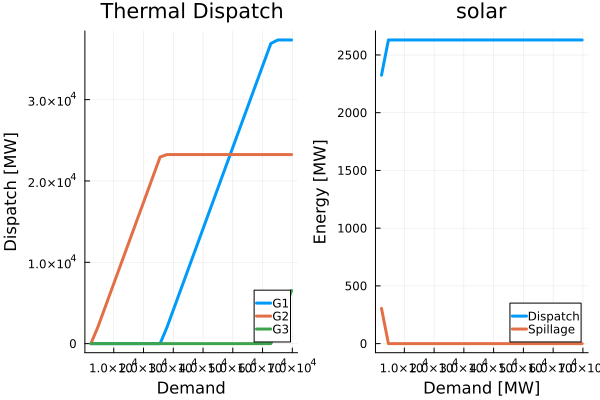

In [520]:
#g2까지 있었으나 g3추가

dispatch_plot = StatsPlots.@df(
    demand_scale_df,
    Plots.plot(
        :demand,
        [:dispatch_G1, :dispatch_G2, :dispatch_G3],
        labels = ["G1" "G2" "G3"],
        title = "Thermal Dispatch",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand",
        ylabel = "Dispatch [MW]",
    ),
)

solar_plot = StatsPlots.@df(
    demand_scale_df,
    Plots.plot(
        :demand,
        [:dispatch_solar, :spillage_solar],
        labels = ["Dispatch" "Spillage"],
        title = "solar",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand [MW]",
        ylabel = "Energy [MW]",
    ),
)

Plots.plot(dispatch_plot, solar_plot)

In [521]:
function solve_unit_commitment(generators::Vector, solar, scenario)
    model = Model(CPLEX.Optimizer)
    set_silent(model)
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    @variable(model, 0 <= w <= scenario.solar)
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    # !!! New: add binary on-off variables for each generator
    @variable(model, u[i = 1:N], Bin)
    @constraint(model, [i = 1:N], g[i] <= generators[i].max * u[i])
    @constraint(model, [i = 1:N], g[i] >= generators[i].min * u[i])
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        solar.variable_cost * w +
        # !!! new
        sum(generators[i].fixed_cost * u[i] for i in 1:N)
    )
    optimize!(model)
    status = termination_status(model)
    if status != OPTIMAL
        return (status = status,)
    end
    return (
        status = status,
        g = value.(g),
        w = value(w),
        solar_spill = scenario.solar - value(w),
        u = value.(u),
        total_cost = objective_value(model),
    )
end


solve_unit_commitment (generic function with 1 method)

In [522]:
solution = solve_unit_commitment(generators, solar_generator, scenario)

println("Dispatch of Generators: ", solution.g, " MW")
println("Commitments of Generators: ", solution.u)
println("Dispatch of Solar: ", solution.w, " MW")
println("Solar spillage: ", solution.solar_spill, " MW")
println("Total cost: \$", solution.total_cost)

Dispatch of Generators: [0.0, 20621.0, 0.0] MW
Commitments of Generators: [0.0, 1.0, 0.0]
Dispatch of Solar: 2630.0 MW
Solar spillage: 0.0 MW
Total cost: $3.12345e6


In [523]:
#g2까지 있었으나 g3추가

uc_df = DataFrames.DataFrame(;
    demand = Float64[],
    commitment_G1 = Float64[],
    commitment_G2 = Float64[],
    commitment_G3 = Float64[],
    dispatch_G1 = Float64[],
    dispatch_G2 = Float64[],
    dispatch_G3 = Float64[],
    dispatch_solar = Float64[],
    spillage_solar = Float64[],
    total_cost = Float64[],
)


Row,demand,commitment_G1,commitment_G2,commitment_G3,dispatch_G1,dispatch_G2,dispatch_G3,dispatch_solar,spillage_solar,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [524]:
#g2까지 있었으나 g3추가


for demand_scale in 0.2:0.1:1.4
    new_scenario = scale_demand(scenario, demand_scale)
    sol = solve_unit_commitment(generators, solar_generator, new_scenario)
    #sol = solve_unit_commitment(generators, solar, new_scenario)
    if sol.status == OPTIMAL
        push!(
            uc_df,
            (
                new_scenario.demand,
                sol.u[1],
                sol.u[2],
                sol.u[3],
                sol.g[1],
                sol.g[2],
                sol.g[3],
                sol.w,
                sol.solar_spill,
                sol.total_cost,
            ),
        )
    end
    println("Status: $(sol.status) for demand_scale = $(demand_scale)")
end

Status: OPTIMAL for demand_scale = 0.2
Status: OPTIMAL for demand_scale = 0.3
Status: OPTIMAL for demand_scale = 0.4
Status: OPTIMAL for demand_scale = 0.5
Status: OPTIMAL for demand_scale = 0.6
Status: OPTIMAL for demand_scale = 0.7
Status: OPTIMAL for demand_scale = 0.8
Status: OPTIMAL for demand_scale = 0.9
Status: OPTIMAL for demand_scale = 1.0
Status: OPTIMAL for demand_scale = 1.1
Status: OPTIMAL for demand_scale = 1.2
Status: OPTIMAL for demand_scale = 1.3
Status: OPTIMAL for demand_scale = 1.4


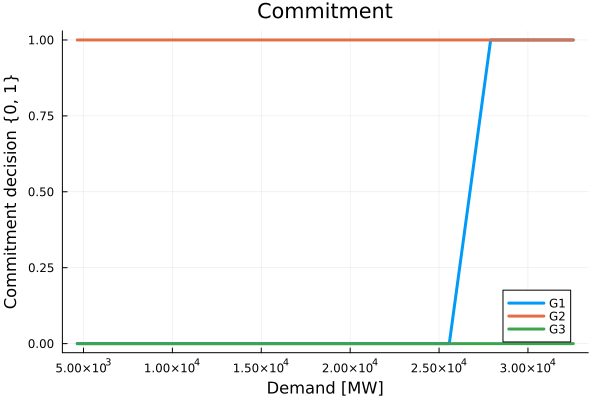

In [525]:
commitment_plot = StatsPlots.@df(
    uc_df,
    Plots.plot(
        :demand,
        [:commitment_G1, :commitment_G2, :commitment_G3],
        labels = ["G1" "G2" "G3"],
        title = "Commitment",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand [MW]",
        ylabel = "Commitment decision {0, 1}",
    ),
)


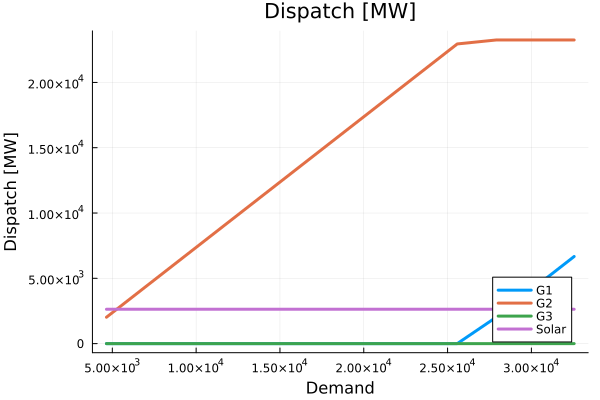

In [526]:
dispatch_plot = StatsPlots.@df(
    uc_df,
    Plots.plot(
        :demand,
        [:dispatch_G1, :dispatch_G2, :dispatch_G3, :dispatch_solar],
        labels = ["G1" "G2" "G3" "Solar"],
        title = "Dispatch [MW]",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand",
        ylabel = "Dispatch [MW]",
    ),
)


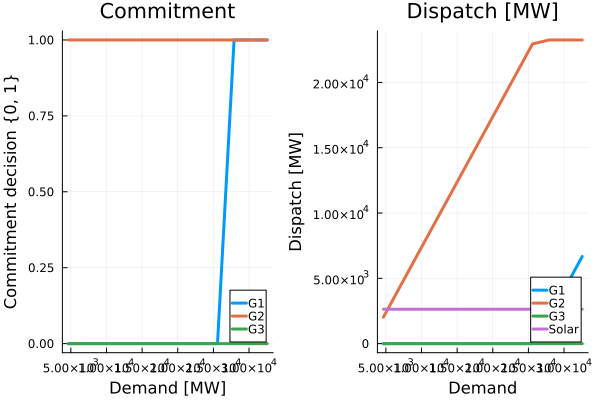

In [527]:
Plots.plot(commitment_plot, dispatch_plot)

In [528]:
import Ipopt

"""
    thermal_cost_function(g)

A user-defined thermal cost function in pure-Julia! You can include
nonlinearities, and even things like control flow.

!!! warning
    It's still up to you to make sure that the function has a meaningful
    derivative.
"""
function thermal_cost_function(g)
    if g <= 500
        return g
    else
        return g + 1e-2 * (g - 500)^2
    end
end

function solve_nonlinear_economic_dispatch(
    generators::Vector,
    solar,
    scenario;
    silent::Bool = false,
)
    model = Model(Ipopt.Optimizer)
    if silent
        set_silent(model)
    end
    register(model, :tcf, 1, thermal_cost_function; autodiff = true)
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    @variable(model, 0 <= w <= scenario.solar)
    @NLobjective(
        model,
        Min,
        sum(generators[i].variable_cost * tcf(g[i]) for i in 1:N) +
        solar.variable_cost * w,
    )
    @NLconstraint(model, sum(g[i] for i in 1:N) + sqrt(w) == scenario.demand)
    optimize!(model)
    return (
        g = value.(g),
        w = value(w),
        solar_spill = scenario.solar - value(w),
        total_cost = objective_value(model),
    )
end

solution =
    solve_nonlinear_economic_dispatch(generators, solar_generator, scenario)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4999945e+00 2.33e+04 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

(g = [7597.103519573188, 9026.524223487826, 6576.088731062734], w = 2630.0000262999783, solar_spill = -2.62999783444684e-5, total_cost = 2.81374733925258e8)

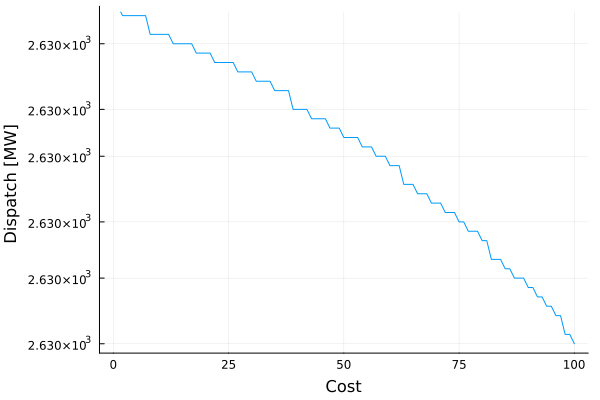

In [529]:
solar_cost = 0.0:1:100
solar_dispatch = Float64[]
for c in solar_cost
    sol = solve_nonlinear_economic_dispatch(
        generators,
        SolarGenerator(c),
        scenario;
        silent = true,
    )
    push!(solar_dispatch, sol.w)
end

Plots.plot(
    solar_cost,
    solar_dispatch;
    xlabel = "Cost",
    ylabel = "Dispatch [MW]",
    label = false,
)